# Description:
This program is for ASTR400B Project.  It will choose a snapshot and bin particles in that snapshot.  It will compare how the particles from each bin are changing during the merger of Andromeda and the Milky Way.  The main focus is to look at the tidal arms and bridges of created and where the particles came from in the merger.  

Authur: Andrew Henrici  
Date last modified: 4/19/2018

In [1]:
%matplotlib notebook
# Import analysis packages
import numpy as np
from scipy import stats
from scipy import interpolate
import astropy.units as u
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import pandas as pd

# Import plotting packages
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Import my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile
from RotateFrame import RotateFrame
from Binmaker import binmaker

In [2]:
# Global values

# Comparison radius for n5
ro = 1000

# Define list of colors to cycle through
c = ['b','g','r','c','m','y','k']

In [3]:
# Coordinate Transformations

# Transform from cartesian to  spherical
def cart2sph(self, x, y, z):
    # Input the cartesian coordinates and 
    # returns the spherical
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    phi = np.arctan2(z, hxy)
    theta = np.arctan2(y, x)
    return r, theta, phi


In [4]:
# Find the nearest five particles in the bin and get the distances of them
def nearest_five(data):
    n5 = np.ones((len(data), 5))*r0
    for i in range(len(data)):
        for j in range(len(data)):
            if j != i:
                r = np.sqrt((data[i,0] - data[j,0])**2+(data[i,1] - data[j,1])**2+(data[i,2] - data[j,2])**2)
                for k in range(5):
                    if n5[i,k] == r0 and r<n5[i,k]:
                        n5[i,k] = r
                        break
    return n5

In [5]:
# Bins the particles to the closest test point(point on curve fit).
# Each particle is given the number of the closest stored in index
def Find_Local(data, points):
    index = np.zeros(len(data))
    for j in range(len(data)):
        d = data[j]
        delta_r = 1000
        closest_point = 0
        for i in range(len(points)):
            p = points[i]
            r = np.sqrt((d[0]-p[0])**2 + (d[1]-p[1])**2 + (d[2]-p[2])**2)
            if r < delta_r:
                delta_r = r
                closest_point = i
        index[j] = closest_point
    return index

In [6]:

def recenter(data, points, index):
    new_list = np.zeros((len(points),3), dtype = float)
    for i in range(len(points)):
        p = points[i]
        close = data[np.where(index == i)]
        fx, fy, fz = 0, 0, 0
        for c in close:
            fx += c[0]/len(close)
            fy += c[1]/len(close)
            fz += c[2]/len(close)
        new_list[i, 0] = fx
        new_list[i, 1] = fy
        new_list[i, 2] = fz
    return new_list


In [7]:
# From https://stackoverflow.com/questions/24733185/volume-of-convex-hull-with-qhull-from-scipy

# Calculates the volume of a tetrahedron given by 4 points a, b, c, d
def tetrahedron_volume(a, b, c, d):
    return np.abs(np.einsum('ij,ij->i', a-d, np.cross(b-d, c-d))) / 6

# Calculates total volume of the points given
# not 100% sure how it works, was found on stackoverflow.com
def convex_hull_volume_bis(pts):
    ch = ConvexHull(pts)

    simplices = np.column_stack((np.repeat(ch.vertices[0], ch.nsimplex),
                                 ch.simplices))
    tets = ch.points[simplices]
    return np.sum(tetrahedron_volume(tets[:, 0], tets[:, 1],
                                     tets[:, 2], tets[:, 3]))

In [8]:
# Finds the mean for all of the non-zero values and values that ain't ro
def Mean(inputs):
    good_inp = []
    for i in range(len(inputs)):
        if inputs[i] != ro:
            good_inp.append(inputs[i])
    return sum(good_inp)/len(good_inp)

# Part 1:  Set Initial Bins
Use point in time right before collision to mark "original" positions of the particles to track them.  
Will create radial bins and angular bins.  
The current checkpoint is 281

<IPython.core.display.Javascript object>


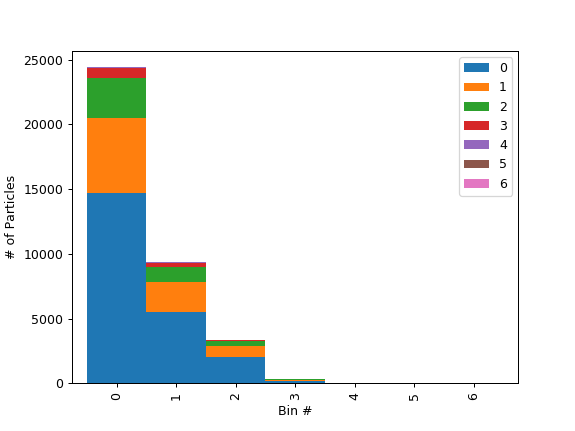

<IPython.core.display.Javascript object>


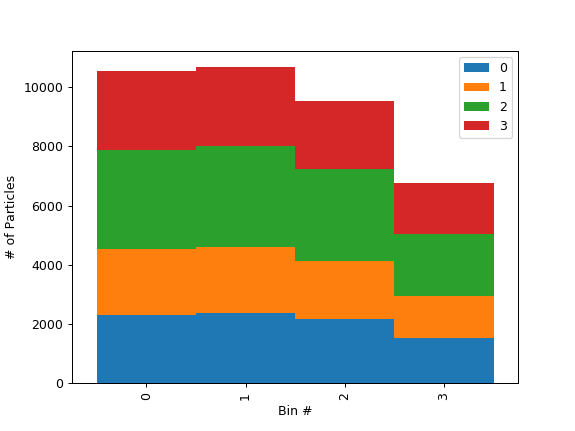

         0       1       2      3     4    5    6
0  14677.0  5811.0  3090.0  781.0  85.0  3.0  1.0
1   5534.0  2310.0  1173.0  296.0  24.0  2.0  0.0
2   2011.0   850.0   388.0   96.0  12.0  2.0  0.0
3    197.0    91.0    35.0   15.0   1.0  0.0  0.0
4     10.0     2.0     2.0    0.0   0.0  0.0  0.0
5      0.0     0.0     0.0    0.0   0.0  0.0  0.0
6      1.0     0.0     0.0    0.0   0.0  0.0  0.0


In [9]:
# Decide number of bins
N_Rad = 7
N_Ang = 4

# Create nxn matrices for comparative histograms between two times
rad = np.zeros((N_Rad, N_Rad))
ang = np.zeros((N_Ang, N_Ang))

# Call the bin maker to create bins for the checkpoint and another time
bin_t0 = binmaker("MW_281.txt")
bin_tf = binmaker("MW_282.txt")

# Create the bins for the checkpoint
Radial0 = bin_t0.Radial_Bins(N_Rad)
Angular0 = bin_t0.Angular_Bins(N_Ang)

# Create the bins for the other time
Radialf= bin_tf.Radial_Bins(N_Rad)
Angularf = bin_tf.Angular_Bins(N_Ang)

# Run throuch all combination of bins and find the number of particles that 
# is in both bins
for i in range(N_Rad):
    for j in range(N_Rad):
        # Count the number of particles in each bin and write to the corresponding
        # point of the matrix
        rad[i,j] = len(np.where((Radial0 == i) & (Radialf == j))[0])

# Run throuch all combination of bins and find the number of particles that 
# is in both bins
for i in range(N_Ang):
    for j in range(N_Ang):
        # Count the number of particles in each bin and write to the corresponding
        # point of the matrix
        ang[i,j] = len(np.where((Angular0 == i) & (Angularf == j) & (Radialf >= 0))[0])
        
# send the particles to the dataframes to be plotted in a stack plot
# Radial plot
Rad = pd.DataFrame(rad.transpose())
Rad.plot.bar(stacked=True, width=1)
plt.xlabel("Bin #")
plt.ylabel("# of Particles")

# Angular plot
Ang = pd.DataFrame(ang.transpose())
Ang.plot.bar(stacked=True, width=1)
plt.xlabel("Bin #")
plt.ylabel("# of Particles")

print(Rad)

<IPython.core.display.Javascript object>


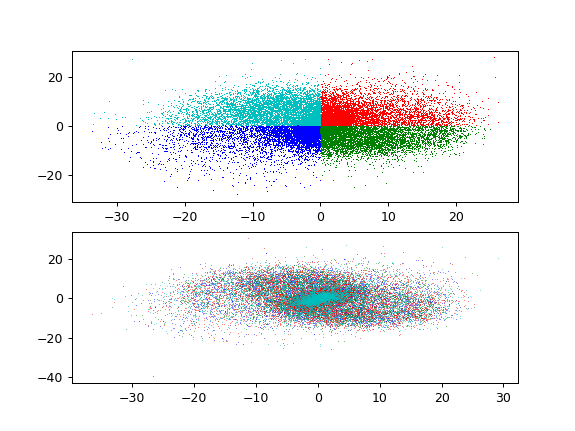

(array([3595]),)


In [10]:
# Define figure
plt.figure()

plt1=plt.subplot(211)
plt2=plt.subplot(212)

# Define initial snapshot
snapshot = 281

# Store the COM of the Milky Way to center on
COMD = CenterOfMass("MW_{}.txt".format(snapshot), 2)
COMP = COMD.COM_P(0.1, 4.0)

# Recenter to COM position
xD = COMD.x - float(COMP[0]/u.kpc)
yD = COMD.y - float(COMP[1]/u.kpc)
zD = COMD.z - float(COMP[2]/u.kpc)

# Store the COM of the Milky Way to center on for the second time
COMD = CenterOfMass("MW_{}.txt".format(snapshot+1), 2)
COMP = COMD.COM_P(0.1, 4.0)

# Recenter to COM position for second time
xB = COMD.x - float(COMP[0]/u.kpc)
yB = COMD.y - float(COMP[1]/u.kpc)
zB = COMD.z - float(COMP[2]/u.kpc)

# Convert COM to spherical
for i in range(N_Ang):
    index = np.where(Angular0 == i)
    
    plt1.plot(xD[index], yD[index], ',', color=c[i])
    plt2.plot(xB[index], yB[index], ',', color=c[i], alpha=0.5)
    
print(np.where(Radial0 == 6))

<IPython.core.display.Javascript object>


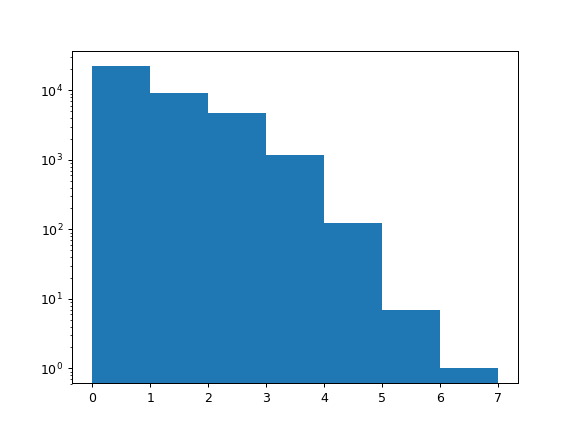

(array([2.243e+04, 9.064e+03, 4.688e+03, 1.188e+03, 1.220e+02, 7.000e+00,
        1.000e+00]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

In [11]:
# Plot log distribution of the galaxy
plt.figure()
plt.hist(Radial0, log=True, bins=[0,1,2,3,4,5,6,7])

<IPython.core.display.Javascript object>


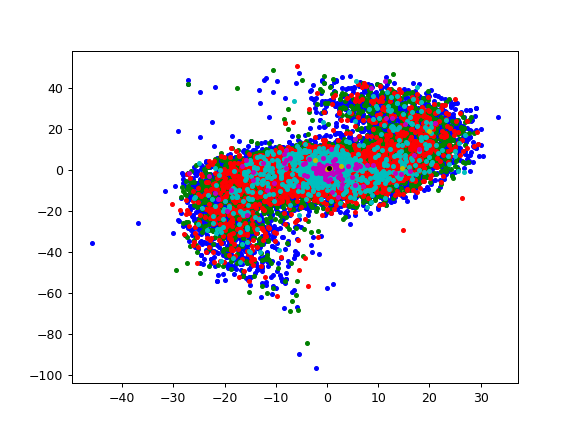

In [12]:
#Plot the points with bin colors for 300


# Store the COM of the Milky Way to center on
COMD = CenterOfMass("MW_300.txt",2)
COMP = COMD.COM_P(0.1, 4.0)

# Recenter to COM position
xD = COMD.x - float(COMP[0]/u.kpc)
yD = COMD.y - float(COMP[1]/u.kpc)
zD = COMD.z - float(COMP[2]/u.kpc)

# Plot the particles according to their bins
fig = plt.figure()
for i in range(N_Rad):
    index = np.where(Radial0 == i)
    plt.plot(xD[index], yD[index], '.', color=c[i])

<IPython.core.display.Javascript object>


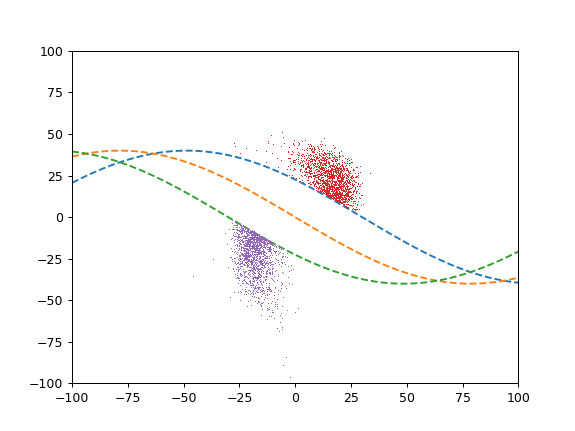

In [13]:
# Plot the cut regions
fig = plt.figure()

# plot the cuts

plt.xlim(-100.,100.)
plt.ylim(-100.,100.)

X = np.linspace(-100., 100., 100)
plt.plot(X, -40.*np.sin((X-30.)/50.), '--')
plt.plot(X, -40.*np.sin(X/50.), '--')
plt.plot(X, -40.*np.sin((X+30.)/50.), '--')

lower_index = np.where(yD <= -40.*np.sin((xD+30)/50))
upper_index = np.where(yD >= -40.*np.sin((xD-30.)/50.))

xl, yl, zl = xD[lower_index], yD[lower_index], zD[lower_index]
xu, yu, zu = xD[upper_index], yD[upper_index], zD[upper_index]

plt.plot(xu, yu, ',')
plt.plot(xl, yl, ',')


<IPython.core.display.Javascript object>


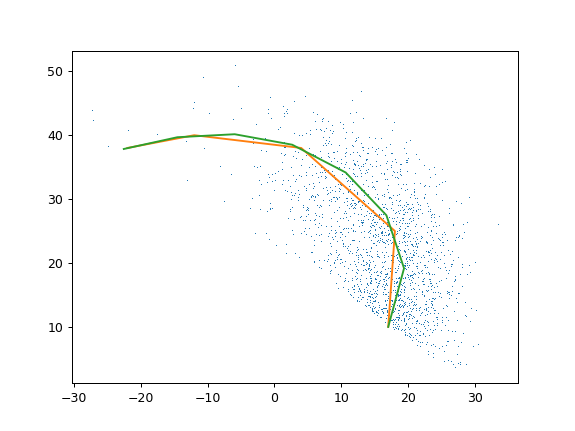

In [14]:
# Plot the test points of the spline
fig = plt.figure()

test_points = np.array([[17, 10, 0],
                        [18, 25, 0],
                        [4, 38, -2],
                        [-12, 40, -6],
                        [-22, 38, -10]])

plt.plot(xu, yu, ',')
plt.plot(test_points[:,0], test_points[:,1])

tck, _u = interpolate.splprep([test_points[:,0], test_points[:,1], test_points[:, 2]], s=0)
unew = np.linspace(0, 1.01, 8)
out = interpolate.splev(unew, tck)
plt.plot(out[0], out[1])

In [15]:
# Bin the particles to the closest point on the curve 
# then find the center of those particles and re-index 
data = np.transpose(np.array([xu, yu, zu]))
path = np.transpose(out)
index = Find_Local(data, path)
new_list = recenter(data, path, index)
index = Find_Local(data, new_list)

<IPython.core.display.Javascript object>


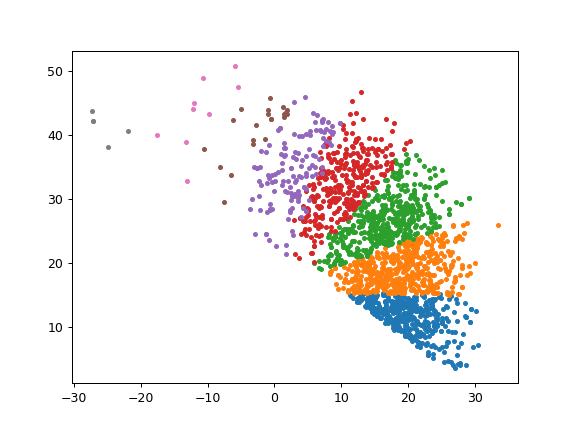

In [16]:
# Plot the particles to their new bin
plt.figure()
for i in range(8):
    p1 = data[np.where(index == i)]
    plt.plot(p1[:,0], p1[:,1],'.')

In [17]:
# Find the volume of each bin
index = Find_Local(data, new_list)

volume = np.zeros(len(new_list))

for i in range(len(test_points)):
    p1 = data[np.where(index == i)]
    
    volume[i] = convex_hull_volume_bis(p1)
   